
# Spaceship Titanic - Complete Analysis & Modeling

**Authors**: Batuhan Görkey (bloom), Kaan AK (kebolover)

This notebook provides a complete pipeline for the Spaceship Titanic competition:
1. Data Reading and Exploratory Analysis
2. Missing Value Handling
3. Feature Engineering
4. Model Training with RandomForest, XGBoost, CatBoost, LightGBM
5. Ensemble
6. Submission



# 1. Importing Libraries



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ML Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

# Display settings
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

# Random seed
RANDOM_STATE = 42


# 2. Reading the Data

We read both train and test CSV files. 


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape :", test.shape)
train.head()


Train shape: (8693, 14)
Test shape : (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
# Quick look at test as well
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


# 3. Exploratory Data Analysis (EDA)

- Check missing values
- Target distribution
- Numerical/Categorical distributions

Missing values in train:
 CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

Missing values in test:
 FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64

Transported distribution:
 Transported
True     4378
False    4315
Name: count, dtype: int64


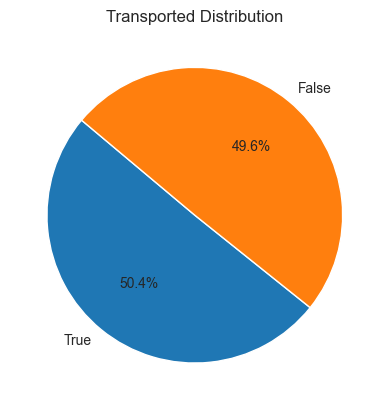

In [4]:
# Missing values
print("Missing values in train:\n", train.isnull().sum().sort_values(ascending=False))
print("\nMissing values in test:\n", test.isnull().sum().sort_values(ascending=False))

# Target distribution
print("\nTransported distribution:\n", train["Transported"].value_counts())

# Pie chart
fig, ax = plt.subplots()
train["Transported"].value_counts().plot.pie(
    labels=["True","False"], autopct="%1.1f%%", startangle=140, ax=ax
)
ax.set_ylabel("")
ax.set_title("Transported Distribution")
plt.show()


In [5]:
# Basic stats for numerical features
num_cols = ["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]
train[num_cols].describe()


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


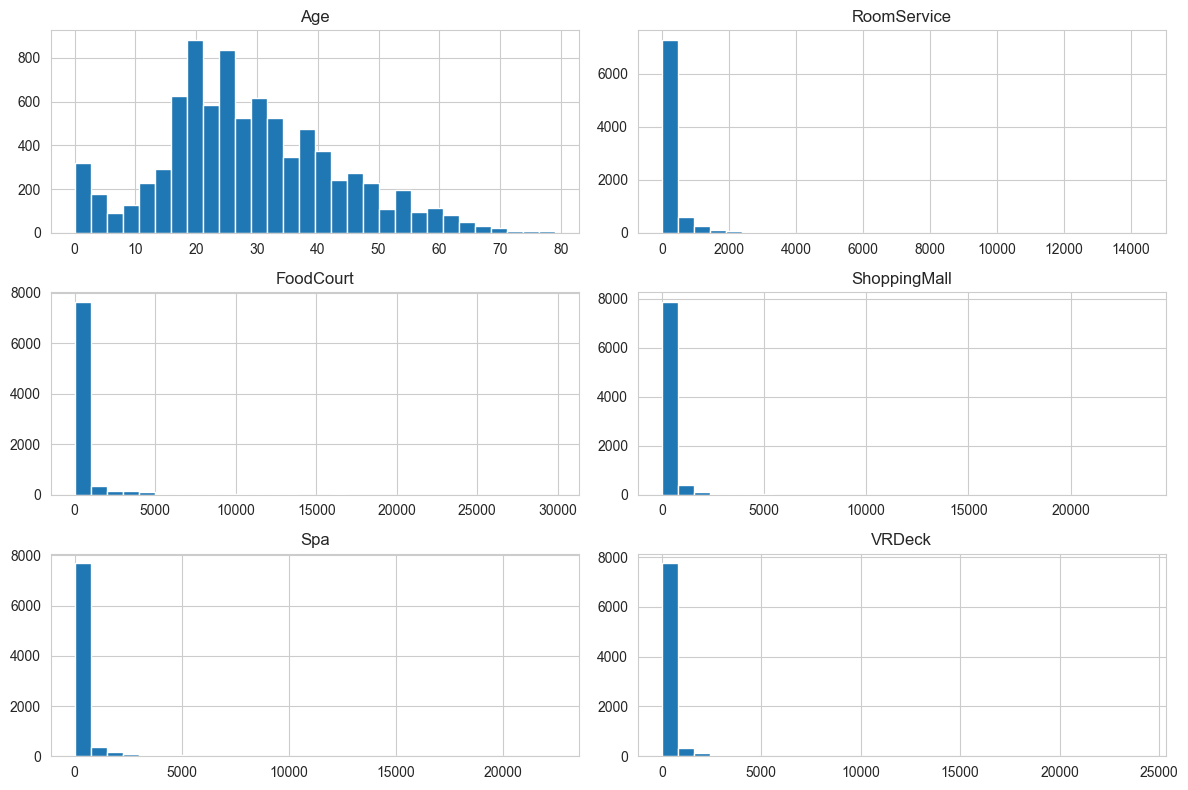

In [6]:
# Histograms for numeric columns
num_cols = ["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]
train[num_cols].hist(figsize=(12,8), bins=30)
plt.tight_layout()
plt.show()



# 4. Data Preprocessing & Feature Engineering

- We will create new features (GroupID, GroupSize, TotalSpending, NoSpending).
- We will split "Cabin" into deck/num/side.
- Then we handle missing values and perform encoding for categorical columns.

In [7]:
# 4.1 Create GroupID & GroupSize
train["GroupID"] = train["PassengerId"].apply(lambda x: x.split("_")[0])
test["GroupID"] = test["PassengerId"].apply(lambda x: x.split("_")[0])

train_group_size = train["GroupID"].value_counts()
test_group_size = test["GroupID"].value_counts()

train["GroupSize"] = train["GroupID"].map(train_group_size)
test["GroupSize"] = test["GroupID"].map(test_group_size)


In [8]:
# 4.2 Split Cabin
train[["Deck","CabinNum","Side"]] = train["Cabin"].str.split("/", expand=True)
test[["Deck","CabinNum","Side"]] = test["Cabin"].str.split("/", expand=True)

train.drop(["Name","Cabin"], axis=1, inplace=True)
test.drop(["Name","Cabin"], axis=1, inplace=True)

# Convert CabinNum to numeric
train["CabinNum"] = pd.to_numeric(train["CabinNum"], errors="coerce")
test["CabinNum"] = pd.to_numeric(test["CabinNum"], errors="coerce")


In [9]:
# 4.3 Create TotalSpending & NoSpending
spend_cols = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]
train["TotalSpending"] = train[spend_cols].sum(axis=1)
test["TotalSpending"] = test[spend_cols].sum(axis=1)

train["NoSpending"] = (train["TotalSpending"] == 0).astype(int)
test["NoSpending"] = (test["TotalSpending"] == 0).astype(int)


In [ ]:
# 4.4 Fill Missing Values
# Numeric columns > 0 or median
for c in spend_cols:
    train[c] = train[c].fillna(0)
    test[c] = test[c].fillna(0)

train["Age"] = train["Age"].fillna(train["Age"].median())
test["Age"] = test["Age"].fillna(test["Age"].median())

train["CabinNum"] = train["CabinNum"].fillna(train["CabinNum"].median())
test["CabinNum"] = test["CabinNum"].fillna(test["CabinNum"].median())

# Boolean columns > fillna(False)
train["CryoSleep"] = train["CryoSleep"].fillna(False)
test["CryoSleep"] = test["CryoSleep"].fillna(False)

train["VIP"] = train["VIP"].fillna(False)
test["VIP"] = test["VIP"].fillna(False)

# Categorical > fill with "Unknown"
train["HomePlanet"] = train["HomePlanet"].fillna("Unknown")
test["HomePlanet"] = test["HomePlanet"].fillna("Unknown")

train["Destination"] = train["Destination"].fillna("Unknown")
test["Destination"] = test["Destination"].fillna("Unknown")

# Fill Deck/Side with "U" if missing
train["Deck"] = train["Deck"].fillna("U")
train["Side"] = train["Side"].fillna("U")

test["Deck"] = test["Deck"].fillna("U")
test["Side"] = test["Side"].fillna("U")


C:\Users\kaana\AppData\Local\Temp\ipykernel_269684\1488801143.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train["CryoSleep"] = train["CryoSleep"].fillna(False)
C:\Users\kaana\AppData\Local\Temp\ipykernel_269684\1488801143.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test["CryoSleep"] = test["CryoSleep"].fillna(False)
C:\Users\kaana\AppData\Local\Temp\ipykernel_269684\1488801143.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy

In [11]:
# Check if missing remains
print("Train missing after fill:\n", train.isnull().sum())
print("\nTest missing after fill:\n", test.isnull().sum())


Train missing after fill:
 PassengerId      0
HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Transported      0
GroupID          0
GroupSize        0
Deck             0
CabinNum         0
Side             0
TotalSpending    0
NoSpending       0
dtype: int64

Test missing after fill:
 PassengerId      0
HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
GroupID          0
GroupSize        0
Deck             0
CabinNum         0
Side             0
TotalSpending    0
NoSpending       0
dtype: int64


In [12]:
# 4.5 Convert booleans to int
train["CryoSleep"] = train["CryoSleep"].astype(int)
test["CryoSleep"] = test["CryoSleep"].astype(int)

train["VIP"] = train["VIP"].astype(int)
test["VIP"] = test["VIP"].astype(int)


In [ ]:
# 4.6 One tot Encode categorical columns
cat_cols = ["HomePlanet","Destination","Deck","Side"]

train = pd.get_dummies(train, columns=cat_cols, drop_first=True)
test = pd.get_dummies(test, columns=cat_cols, drop_first=True)

# Align columns
missing_cols = set(train.columns) - set(test.columns)
for c in missing_cols:
    if c != "Transported":
        test[c] = 0

extra_cols = set(test.columns) - set(train.columns)
for c in extra_cols:
    test.drop(c, axis=1, inplace=True)


# 5. Correlation Heatmap (Numeric)
We'll plot a heatmap for numeric columns including Transported.


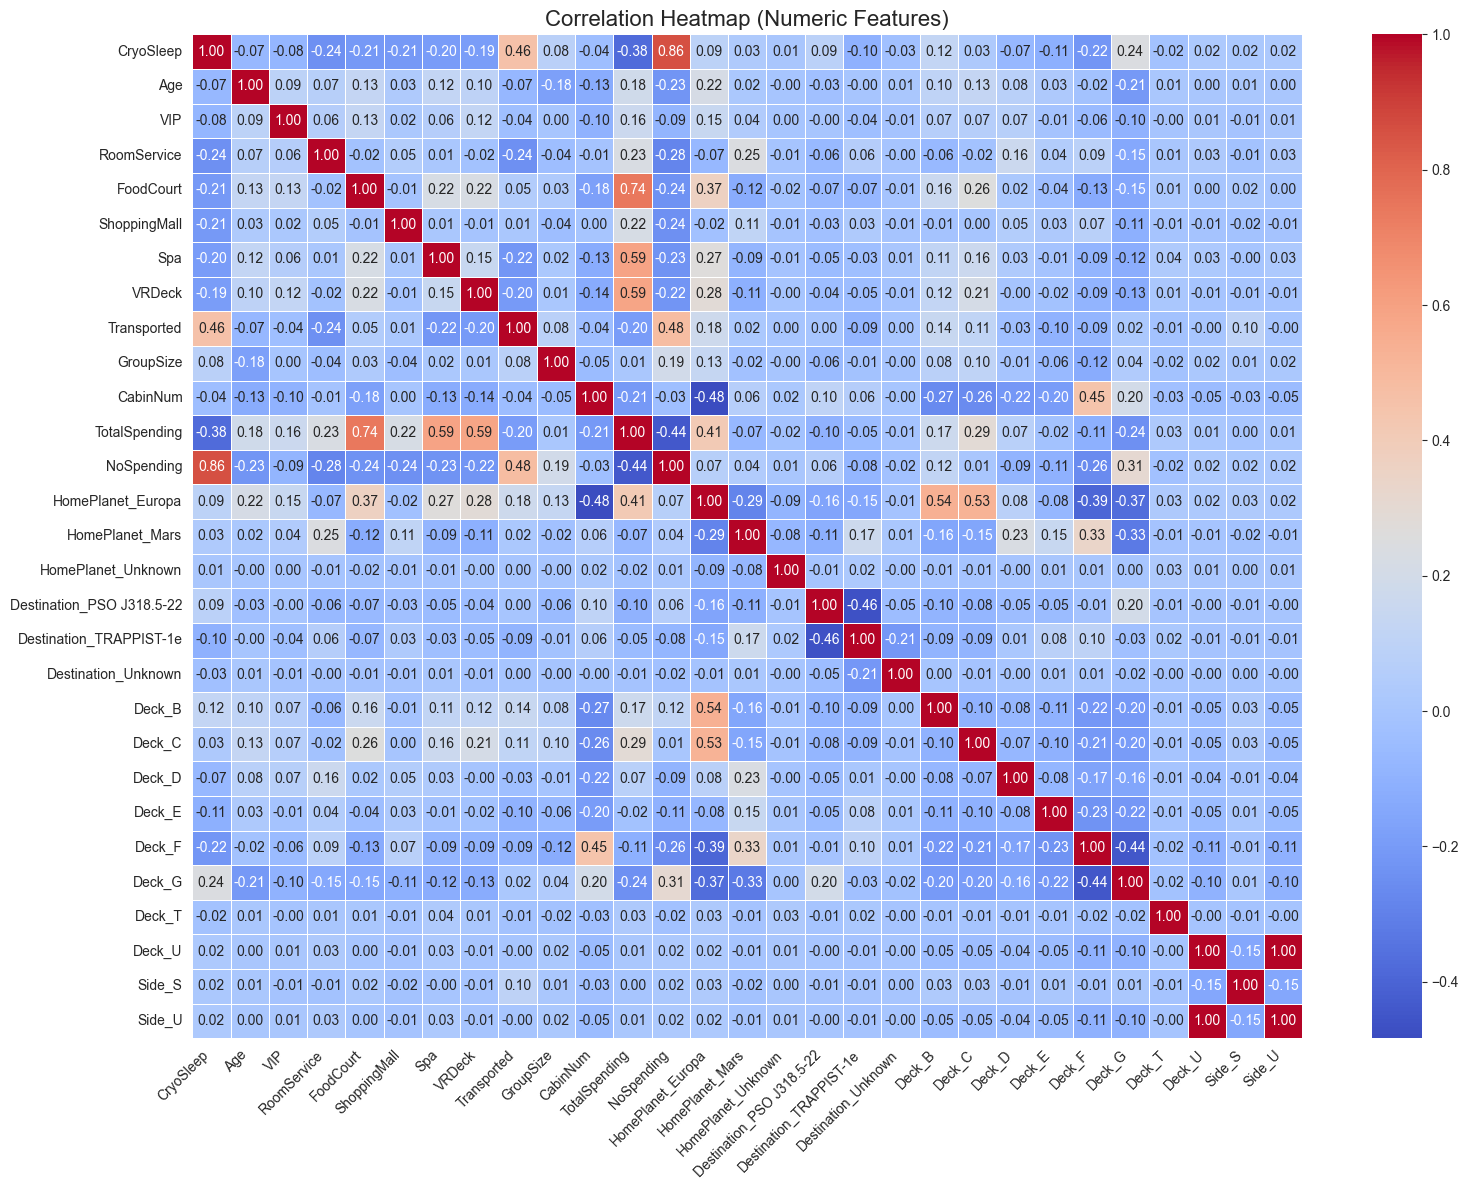

In [14]:
numeric_cols = []
for col in train.columns:
    if pd.api.types.is_numeric_dtype(train[col]):
        numeric_cols.append(col)

corr_matrix = train[numeric_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix, 
    annot=True,     
    fmt=".2f",      
    cmap="coolwarm",
    linewidths=0.5, 
    cbar=True
)

plt.title("Correlation Heatmap (Numeric Features)", fontsize=16)
plt.xticks(rotation=45, ha="right")  
plt.yticks(rotation=0)               
plt.tight_layout()
plt.show()



# 6. Modeling
We'll train RandomForest, XGBoost, CatBoost, LightGBM and do a simple ensemble.

In [15]:
# Prepare data
X = train.drop(["Transported","PassengerId","GroupID"], axis=1)
y = train["Transported"].astype(int)

X_test_final = test.drop(["PassengerId","GroupID"], axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (6954, 28)
y_train shape: (6954,)


In [16]:
# 6.1 RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)
rf_acc = accuracy_score(y_val, rf_pred)
print(f"RandomForest Accuracy: {rf_acc:.4f}")


RandomForest Accuracy: 0.8051


In [17]:
# 6.2 XGBoost
xgb_model = XGBClassifier(
    random_state=RANDOM_STATE,
    use_label_encoder=False,   # Remove warning
    eval_metric="logloss"
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)
xgb_acc = accuracy_score(y_val, xgb_pred)
print(f"XGBoost Accuracy: {xgb_acc:.4f}")


c:\Users\kaana\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:27:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8229


In [18]:
# 6.3 CatBoost
cat_model = CatBoostClassifier(
    random_state=RANDOM_STATE,
    verbose=0
)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_val)
cat_acc = accuracy_score(y_val, cat_pred)
print(f"CatBoost Accuracy: {cat_acc:.4f}")


CatBoost Accuracy: 0.8166


In [19]:
# 6.4 LightGBM
lgb_model = lgb.LGBMClassifier(random_state=RANDOM_STATE)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_val)
lgb_acc = accuracy_score(y_val, lgb_pred)
print(f"LightGBM Accuracy: {lgb_acc:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
LightGBM Accuracy: 0.8097


In [ ]:
# Compare models for clear understanding
model_scores = {
    "RandomForest": rf_acc,
    "XGBoost": xgb_acc,
    "CatBoost": cat_acc,
    "LightGBM": lgb_acc
}

print("\nModel Validation Accuracies:")
for m, s in model_scores.items():
    print(f"{m}: {s:.4f}")



Model Validation Accuracies:
RandomForest: 0.8051
XGBoost: 0.8229
CatBoost: 0.8166
LightGBM: 0.8097



# 7. Simple Ensemble (Soft Voting)


In [21]:
rf_proba = rf_model.predict_proba(X_val)[:, 1]
xgb_proba = xgb_model.predict_proba(X_val)[:, 1]
cat_proba = cat_model.predict_proba(X_val)[:, 1]
lgb_proba = lgb_model.predict_proba(X_val)[:, 1]

ensemble_proba = (rf_proba + xgb_proba + cat_proba + lgb_proba) / 4.0
ensemble_pred = (ensemble_proba >= 0.5).astype(int)
ensemble_acc = accuracy_score(y_val, ensemble_pred)
print(f"Ensemble Accuracy: {ensemble_acc:.4f}")


Ensemble Accuracy: 0.8200



# 8. Submission
We create final predictions on the test set using the ensemble approach.


In [ ]:
# Test set ensemble
rf_test_proba = rf_model.predict_proba(X_test_final)[:, 1]
xgb_test_proba = xgb_model.predict_proba(X_test_final)[:, 1]
cat_test_proba = cat_model.predict_proba(X_test_final)[:, 1]
lgb_test_proba = lgb_model.predict_proba(X_test_final)[:, 1]

test_ensemble_proba = (rf_test_proba + xgb_test_proba + cat_test_proba + lgb_test_proba) / 4.0
test_ensemble_pred = (test_ensemble_proba >= 0.5).astype(int)  # 1 or 0

# Convert to boolean if its needed
test_ensemble_bool = (test_ensemble_pred == 1)

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Transported": test_ensemble_bool
})
submission.head()


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [23]:
# Save submission
submission.to_csv("submission.csv", index=False)
print("Submission file 'submission.csv' created.")


Submission file 'submission.csv' created.
